##### ~/.keras/keras.json

    {
        "image_dim_ordering": "th" | "tf",
        "image_data_format": "channels_first", | "image_data_format": "channels_last",
        "epsilon": 1e-07,
        "floatx": "float32",
        "backend": "theano" | "tensorflow"
    }
    
select parameters whether you run model on theano or tensorflow
in this notebook, model is run on tensorflow x python 3.6 

In [1]:
from __future__ import division, print_function

%matplotlib inline

import numpy as np
import matplotlib
import os, json
import matplotlib.pyplot as plt

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
#from keras import applications
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [3]:
# Mean of each channel as provided by VGG researchers
#vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1)) #theano complient
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,3)) #tensorflow complient
#vgg_mean.shape

In [4]:
#preprocess data (rearrange RGB + normalize)
def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    #print(x)
    #print(x.shape)
    return x[:, ::-1]    # reverse axis bgr->rgb

In [5]:
#convolutional block definition
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
#fully connected block definition
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    

#define the VGG model architecture
def VGG_16(weights_path=None):
    model = Sequential()
#   model.add(Lambda(vgg_preprocess, input_shape=(3,224,224))) #theano complient
    model.add(Lambda(vgg_preprocess, input_shape=(224,224,3))) #tensorflow complient

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
        
    if weights_path:
        model.load_weights(weights_path)
    
    return model

In [6]:
# download pretrained model
#fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
fpath = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5','https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5', cache_subdir='models')

In [23]:
#create the model like any python object
model = VGG_16(fpath)

In [24]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [25]:
#Show it!
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0         
__________

In [26]:
path = "W://vincent-data/datasets/convbattle/"
batch_size = 5

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)
val_imgs, val_labels = next(val_batches)

Found 2378 images belonging to 2 classes.
Found 792 images belonging to 2 classes.


In [27]:
#plotting images + labels (ground truth)
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [28]:
#predict label by finding the index with the largest probability (with np.argmax())
     
def pred_batch(imgs):  
    preds = model.predict(imgs)  
    idxs = np.argmax(preds, axis=1)  

    print('Shape: {}'.format(preds.shape))  
    print('First 5 classes: {}'.format(classes[:5]))  
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))  
    print('Predictions prob/class: ')  
    
    for i in range(len(idxs)):  
        idx = idxs[i]  
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))  

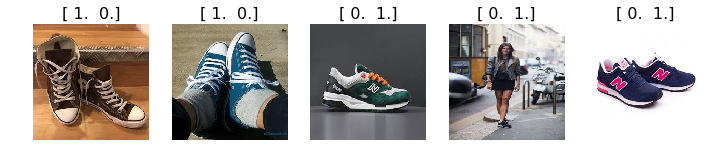

In [29]:
# This shows the 'ground truth'
plots(imgs, titles=labels)

In [30]:
pred_batch(imgs)

Shape: (5, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  7.35678577e-06   3.11843564e-06   1.91952325e-02   3.77365313e-02
   1.10454357e-03]

Predictions prob/class: 
  0.1743/zebra
  0.1178/sandal
  0.1677/packet
  0.0740/goblet
  0.4093/parachute


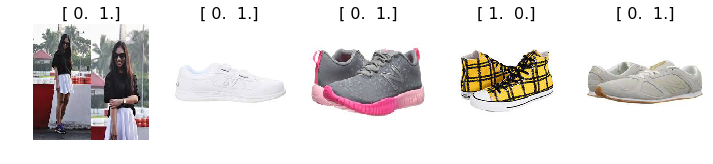

In [31]:
plots(val_imgs, titles=val_labels)

In [32]:
pred_batch(val_imgs)

Shape: (5, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  5.80816777e-06   1.56707356e-05   6.24939639e-05   2.36360429e-04
   1.93354744e-03]

Predictions prob/class: 
  0.1674/punching_bag
  0.0820/whistle
  0.2811/hair_slide
  0.3928/hair_slide
  0.3934/sunglass
